In [277]:
import numpy as np

def trap_sing(a, b, fa, fb):
    h = (b - a)
    I = (h / 2) * (fa + fb)
    return I

def simp_sing(a, b, fa, fm, fb):
    h = (b - a) / 2
    I = (h / 3) * (fa+4*fm+fb)
    return I

def trap_comp(fn, a, b, m):
    h = (b - a) / m
    x = np.linspace(a, b, m+1)
    y = fn(x)
    I = h * (0.5 * (y[0] + y[-1]) + np.sum(y[1:m]))
    return I

def simp_comp(fn, a, b, m):
    n = m if m % 2 == 0 else m + 1
    if m % 2 != 0:
        print("Arrotondato m al primo intero pari superiore")
    h = (b - a) / n
    x = np.linspace(a, b, n+1)
    y = fn(x)
    I = h / 3 * (y[0] + y[-1] + 4 * np.sum(y[1:n:2]) + 2 * np.sum(y[2:n:2]))
    return I

def trap_adapt(fn, a, b, fa, fb, tol, tab):
    m = 0.5*(a+b)
    fm = fn(m)
    tam = trap_sing(a, m, fa, fm)
    tmb = trap_sing(m, b, fm, fb)

    if math.fabs(tab - tam - tmb) / 3 < tol:
        return (4*(tam+tmb)-tab)/3 # Estrapolazione di Richardson
    else:
        return (trap_adapt(fn, a, m, fa, fm, 0.5*tol, tam) + 
                trap_adapt(fn, m, b, fm, fb, 0.5*tol, tmb))

def simp_adapt(fn, a, m, b, fa, fm, fb, tol, sab):
    m1 = 0.5*(a+m)
    m2 = 0.5*(m+b)
    fm1 = fn(m1)
    fm2 = fn(m2)
    sam = simp_sing(a, m, fa, fm1, fm)
    smb = simp_sing(m, b, fm, fm2, fb)
    
    if math.fabs(sab - sam - smb) / 15 < tol:
        return (16*(sam+smb) - sab)/15 # Estrapolazione di Richardson
    else:
        return (simp_adapt(fn, a, m1, m, fa, fm1, fm, 0.5*tol, sam) + 
                simp_adapt(fn, m, m2, b, fm, fm2, fb, 0.5*tol, smb))

def find_m(fn, approx_fn, a, b, exact_value, tolerance, m=2, steps=None):
    if steps is None:
        steps = []
    
    AI = approx_fn(fn, a, b, m)
    error_estimate = abs(AI - exact_value)
    steps.append((m, error_estimate))
    
    if error_estimate < tolerance:
        return steps
    
    return find_m(fn, approx_fn, a, b, exact_value, tolerance, m + 1, steps)

In [282]:
import math
import scipy.integrate as integrate
import unittest

class TestIntegration(unittest.TestCase):    
    def test_trap_comp(self):
        result = trap_comp(lambda x: 1/(1+x), 0, 1, 200)
        self.assertAlmostEqual(result, 0.693147, places=5)
    
    def test_simpson_comp(self):
        result = simp_comp(lambda x: 1/(1+x), 0, 1, 8)
        self.assertAlmostEqual(result, 0.69315, places=5)
        
    def test_find_m(self):
        fn = lambda x: 1/(1+x)
        a = 0; b = 1
        tol = 0.5e-3
        exact_value = integrate.quad(fn, a, b)[0]
        steps = find_m(fn, trap_comp, a, b, exact_value, tol)
        self.assertEqual(steps[-1][0], 12)
        
    def test_trap_adapt(self):
        fn = lambda x: math.e ** math.sin(x)
        a = 0; b = 1 
        fa = fn(a) ; fb = fn(b)
        result = trap_adapt(fn, a, b, fa, fb, 1e-5, trap_sing(a, b, fa, fb))
        self.assertAlmostEqual(result, 1.63186, delta=1e-5)
        
    def test_simp_adapt(self):
        fn = lambda x: math.e ** math.sin(x)
        a = 0; b = 1 ; m = (b-a)/2;  
        fa = fn(a) ; fm = fn(m); fb = fn(b)
        result = simp_adapt(fn, a, m, b, fa, fm, fb, 1e-5, simp_sing(a, b, fa, fm, fb))
        self.assertAlmostEqual(result, 1.63186, delta=1e-5)
        
def run_tests(test_class):
    suite = unittest.TestLoader().loadTestsFromTestCase(test_class)
    unittest.TextTestRunner(verbosity=2).run(suite)
    
run_tests(TestIntegration)

test_find_m (__main__.TestIntegration.test_find_m) ... ok
test_simp_adapt (__main__.TestIntegration.test_simp_adapt) ... ok
test_simpson_comp (__main__.TestIntegration.test_simpson_comp) ... ok
test_trap_adapt (__main__.TestIntegration.test_trap_adapt) ... ok
test_trap_comp (__main__.TestIntegration.test_trap_comp) ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.006s

OK


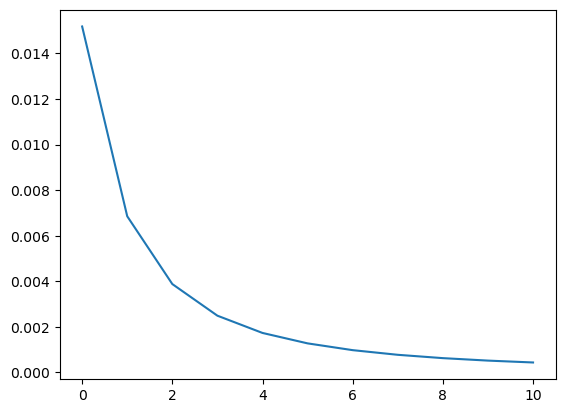

In [269]:
import matplotlib.pyplot as plt

steps = find_m(lambda x: 1/(1+x), trapezi_comp, 0, 1, 0.693147, 0.5e-3)

plt.plot([step[1] for step in steps])